In [ ]:
import torchvision
!pip install qiskit ipywidgets

import torch

from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

use_cuda = torch.cuda.is_available()

print('CUDA available:', use_cuda)

if use_cuda:
    device = torch.device('cuda')
    print('Training on GPU...')
else:
    device = torch.device('cpu')
    print('Training on CPU...')

In [ ]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """

    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(2, 2)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        self.alpha = qiskit.circuit.Parameter('alpha')

        self._circuit.rx(self.theta, all_qubits)
        
        self._circuit.cx(0,1)
        self._circuit.rz(-1*self.alpha, 1)
        self._circuit.cx(0,1)
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas, alphas):

        t_qc = transpile(self._circuit,
                         self.backend)

        param_dict = []
        for i in range (len(alphas)):
          param_dict.append({self.theta:thetas[i].item(),self.alpha:alphas[i].item()} )


        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = param_dict)
        
        job = self.backend.run(qobj)
        result = job.result().get_counts()

        # cálculo da energy expectation
        expectations = 0
        for key in result.keys():
            prob = result[key]/self.shots
            iter_value = -1*(float(key[0])-1/2)*(float(key[1])-1/2)*prob
            expectations += iter_value   

        return [expectations]

In [ ]:
simulator = qiskit.Aer.get_backend('aer_simulator')
circuit = QuantumCircuit(2, simulator, 100)
circuit._circuit.draw()

┌───────────┐                         ░ ┌─┐   
   q_0: ┤ Rx(theta) ├──■──────────────────■───░─┤M├───
        ├───────────┤┌─┴─┐┌────────────┐┌─┴─┐ ░ └╥┘┌─┐
   q_1: ┤ Rx(theta) ├┤ X ├┤ Rz(-alpha) ├┤ X ├─░──╫─┤M├
        └───────────┘└───┘└────────────┘└───┘ ░  ║ └╥┘
   c: 2/═════════════════════════════════════════╬══╬═
                                                 ║  ║ 
meas: 2/═════════════════════════════════════════╩══╩═
                                                 0  1

In [ ]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, inputs, quantum_circuit, shift):
        """ Forward pass computation """

        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = []
        for input in inputs:
            #print(input)
            expectation_z.append(ctx.quantum_circuit.run(input,input))
        result = torch.tensor(expectation_z).cuda()
        
        ctx.save_for_backward(inputs, result)
        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i],shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i],shift_left[i])
            
            gradient = (torch.tensor([expectation_right]).cuda() - torch.tensor([expectation_left]).cuda())*2
            gradients.append(gradient)
        
        # gradients = np.array([gradients]).T
        gradients = torch.tensor([gradients]).cuda()
        gradients = torch.transpose(gradients, 0, 1)

        # return torch.tensor([gradients]).float() * grad_output.float(), None, None
        return gradients.float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(2, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [ ]:
n_samples = 512
batch_size = 32

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

X_train.data = X_train.data[:n_samples]
X_train.targets = X_train.targets[:n_samples]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)

n_samples = 2048

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))


X_test.data = X_test.data[:n_samples]
X_test.targets = X_test.targets[:n_samples]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=batch_size, shuffle=True)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.fc1 = nn.Linear(400, 64)
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(64, 10)
        self.hybrid = [Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2) for i in range(10)] #10 circuitos quanticos

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        x = torch.chunk(x, 10, dim=1)
        x = tuple([hy(x_) for hy, x_ in zip(self.hybrid, x)])
        return torch.cat(x, -1)

In [ ]:
model = Net().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#loss_func = nn.CrossEntropyLoss().cuda()
loss_func = F.nll_loss
epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()

        data = data.cuda()
        target = target.cuda()
        
        # Forward pass
        output = model(data).cuda()

        # Calculating loss
        loss = loss_func(output, target)

        # Backward pass
        loss.backward()

        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))
    
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        
        data = data.cuda()
        target = target.cuda()

        output = model(data).cuda()
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100 / batch_size)
        )

Performance on test data:
	Loss: 2.3022
	Accuracy: 10.5%


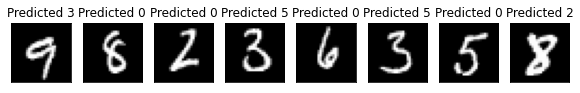

In [ ]:
n_samples_show = 8
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        
        data_cuda = data.cuda()
        target_cuda = target.cuda()

        output_cuda = model(data_cuda).cuda()
        
        pred = output_cuda.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[count].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred[count].item()))
        
        count += 1